<a href="https://colab.research.google.com/github/juno2856/deeplearning/blob/master/NLP/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC_20220526.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# seq2seq 모델

![](https://aiffelstaticprd.blob.core.windows.net/media/images/GN-4-L-7.max-800x600.jpg)

## Encoder 구현

![](https://aiffelstaticprd.blob.core.windows.net/media/images/GN-4-L-6.max-800x600.jpg)

In [ ]:
import tensorflow as tf

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) #( 변수 1, 변수 2) # 나는 밥을 먹었어
        self.lstm = tf.keras.layers.LSTM(enc_units) #( 변수 3 )
    
    def call(self, x):
        print("입력 shape :", x.shape) # sample input // 춤 추는 소시지 

        x = self.embedding(x)
        print("Embedding Layer를 거친 shape :", x.shape)

        output = self.lstm(x)
        print("LSTM shape의 output shape :", output.shape)
        
        return output

In [ ]:
vocab_size = 30000
emb_size = 256
lstm_size = 512
batch_size = 1
sample_seq_len = 3

print("Vocab Size : {0}".format(vocab_size))
print("Embedding Size : {0}".format(emb_size))
print("LSTM Size : {0}".format(lstm_size))
print("Batch_size : {0}".format(batch_size))
print("Sample Sequence Length : {0}".format(sample_seq_len))

Vocab Size : 30000
Embedding Size : 256
LSTM Size : 512
Batch_size : 1
Sample Sequence Length : 3


In [ ]:
encoder = Encoder(vocab_size, emb_size, lstm_size) #vocab_size, embedding_dim, enc_units):
sample_input = tf.zeros((batch_size, sample_seq_len)) # 춤 추는 소시지

sample_output = encoder(sample_input)

입력 shape : (1, 3)
Embedding Layer를 거친 shape : (1, 3, 256)
LSTM shape의 output shape : (1, 512)


## Decoder 구현

![](https://aiffelstaticprd.blob.core.windows.net/media/images/GN-4-L-7.max-800x600.jpg)

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) #(변수 1, 변수 2)
        self.lstm = tf.keras.layers.LSTM(dec_units, return_sequences=True) #(변수 3, return_sequences=True) ####
        self.fc = tf.keras.layers.Dense(vocab_size) #(변수 4)
        self.softmax = tf.keras.layers.Softmax(axis = -1) # None (변수 5)

    def call(self, x, context_v):
        print("입력 shape : ", x.shape)

        x = self.embedding(x)   # (1,3,256)
        print("Embedding layer를 거친 shape", x.shape)

        context_v = tf.repeat(tf.expand_dims(context_v, axis=1), repeats=x.shape[1], axis=1) # (1,512) -> (1,1,512)
        x = tf.concat([x, context_v], axis= -1) # [변수 1, 변수 2], axis = -1)
        print('Context Vector가 더해진 shape : ', x.shape)

        x = self.lstm(x)
        print("LSTM layer의 output layer : ", x.shape)

        output = self.fc(x)
        print("Decoder의 최종 ouput layer : ", output.shape)

        output = self.softmax(output)

        return output

In [ ]:
vocab_size = 30000
emb_size = 256
lstm_size = 512
batch_size = 1
sample_seq_len = 3

print("Vocab Size : {0}".format(vocab_size))
print("Embedding Size : {0}".format(emb_size))
print("LSTM Size : {0}".format(lstm_size))
print("Batch_size : {0}".format(batch_size))
print("Sample Sequence Length : {0}".format(sample_seq_len))

Vocab Size : 30000
Embedding Size : 256
LSTM Size : 512
Batch_size : 1
Sample Sequence Length : 3


In [ ]:
decoder = Decoder(vocab_size, emb_size, lstm_size)
sample_input = tf.zeros((batch_size, sample_seq_len)) # 춤 추는 소시지

sample_output = decoder(sample_input, sample_output)

입력 shape :  (1, 3)
Embedding layer를 거친 shape (1, 3, 256)
Context Vector가 더해진 shape :  (1, 3, 768)
LSTM layer의 output layer :  (1, 3, 512)
Decoder의 최종 ouput layer :  (1, 3, 30000)


# Attention
https://towardsdatascience.com/what-is-teacher-forcing-3da6217fed1c

- Bahdanau Attention
$$ Score_{alignment} = W * tanh(W_{decoder} * H_{decoder} + W_{encoder} * H_{encoder}) $$

In [ ]:
import tensorflow as tf

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_decoder = tf.keras.layers.Dense(units)
        self.w_encoder = tf.keras.layers.Dense(units)
        self.w_combine = tf.keras.layers.Dense(1)
    
    def call(self, h_encoder, h_decoder):
        print("[H_encoder] shape : ", h_encoder.shape)

        h_encoder = self.w_encoder(h_encoder) # Wencoder∗Hencoder
        print("[w_encoder x h_encoder] shape : ", h_encoder.shape)

        print("\n[H_decoder shape :", h_decoder.shape)
        h_decoder = tf.expand_dims(h_decoder, 1)
        h_decoder = self.w_decoder(h_decoder)  # Wdecoder∗Hdecoder

        print("[w_encoder x h_decoder] shape :", h_decoder.shape)

        score = self.w_combine(tf.nn.tanh(h_encoder+h_decoder)) # W
        print("[score alinment] shape :", score.shape)

        attention_weights = tf.nn.softmax(score, axis = -1)
        print("\n최종 weight : \n", attention_weights.numpy())

        context_vector = attention_weights * h_decoder
        context_vector = tf.reduce_sum(context_vector, axis = 1) 

        return context_vector, attention_weights

In [ ]:
w_size = 100
print("hidden state {0}차원으로 Mapping \n".format(w_size))

attention = BahdanauAttention(w_size)

enc_state = tf.random.uniform((1, 10, 512)) # ex 한글 embedding value 
dec_state = tf.random.uniform((1, 512)) # ex  영어 embedding value

_ = attention(enc_state, dec_state)

hidden state 100차원으로 Mapping 

[H_encoder] shape :  (1, 10, 512)
[w_encoder x h_encoder] shape :  (1, 10, 100)

[H_decoder shape : (1, 512)
[w_encoder x h_decoder] shape : (1, 1, 100)
[score alinment] shape : (1, 10, 1)

최종 weight : 
 [[[1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]]]


![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/GN-4-L-9.jpg)

# Loung Attention

$$ Score(H_{target},H_{source}) = H_{target}^T * W_{combine} * H_{source}$$

In [ ]:
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongAttention, self).__init__()
        self.w_combine = tf.keras.layers.Dense(units)

    def call(self, h_encoder, h_decoder):
        print("[h_encoder] shape : ", h_encoder.shape)

        wh = self.w_combine(h_encoder)  # Wcombine∗Hsource
        print("[W_encoder x h_encoder] shape :", wh.shape)

        h_decoder = tf.expand_dims(h_decoder, 1) # 차원 늘리기 
        alignment = tf.matmul(wh, tf.transpose(h_decoder,[0,2,1]))  #HTtarget∗Wcombine∗Hsource
        print("[Score alignment] shape : ", alignment.shape)

        attention_weights = tf.nn.softmax(alignment, axis = 1)
        print("\n 최종 weight : \n", attention_weights.numpy())

        attention_weights = tf.squeeze(attention_weights, axis= -1) # 차원 줄이기 
        context_vector = tf.matmul(attention_weights, h_encoder)

        return context_vector, attention_weights

In [ ]:
emb_dim = 512
attention = LuongAttention(emb_size)

enc_state = tf.random.uniform((1, 10, emb_size))
dec_state = tf.random.uniform((1, emb_size))

_ = attention(enc_state, dec_state)

[h_encoder] shape :  (1, 10, 256)
[W_encoder x h_encoder] shape : (1, 10, 256)
[Score alignment] shape :  (1, 10, 1)

 최종 weight : 
 [[[4.8733419e-01]
  [1.2169003e-01]
  [1.3083021e-01]
  [2.5176516e-02]
  [1.5915568e-03]
  [2.5605627e-03]
  [9.3482621e-02]
  [2.4708272e-03]
  [1.3469312e-01]
  [1.7037426e-04]]]


# Softmax

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [ ]:
pred_logit = np.array([-2, 1.5, -1, 0.5, 2])
pred_prob = softmax(pred_logit)

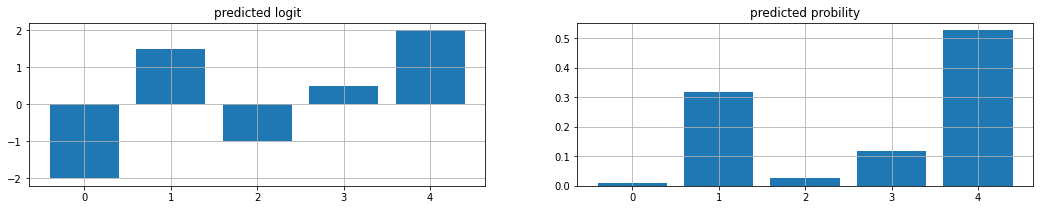

In [ ]:
plt.figure(figsize = [18,3])
plt.subplot(1, 2, 1)
plt.title('predicted logit')
plt.bar(np.arange(len(pred_logit)), pred_logit)
plt.grid()

plt.subplot(1, 2, 2)
plt.title('predicted probility')
plt.bar(np.arange(len(pred_prob)), pred_prob)
plt.grid()
plt.show()